<a href="https://colab.research.google.com/github/sw-programmer/Coursework1/blob/main/CW1_Q1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Coursework 1**

1.   ### **Computationally Efficient Eigenfaces**
2.   ### **Incremental PCA**
3.   ### **PCA-LDA for Face Recognition**
4.   ### **K-means codebook**
5.   ### **RF classifier**


**by 20190223	Soohyun Ryu,	20190247	Sangwoo Park**






**1. Setting!**

In [1]:
import os
import time
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import datetime
# import math
# import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mat_file = io.loadmat("/content/drive/MyDrive/CV_ML/CW1/face.mat")
mat_X = mat_file['X']
mat_Y = mat_file['l'][0]

print(mat_file.keys()) 
print(mat_X.shape)                         # 총 52명. 각 10장의 사진. 

dict_keys(['__header__', '__version__', '__globals__', 'X', 'l'])
(2576, 520)


In [4]:
df = pd.DataFrame(data=mat_X).transpose()
df['label'] = mat_Y                         # row -> data, col -> feature
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values                   # Target column

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    stratify=Y, 
                                                    random_state=1004)          
# 얼굴 그룹 비율 유지               
# test/train ratio = 0.2
# random_state -> before dividing, seed for shuffling
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
np.unique(y_train, return_counts=True)    # 52명의 얼굴이 80%씩 고르게 train set에 들어간 모습

X_train shape: (416, 2576)
X_test shape: (104, 2576)
y_train shape: (416,)
y_test shape: (104,)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52], dtype=uint8),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8]))

## **1. Computationally Efficient Eignefaces**



In [5]:

# 평균 얼굴 계산 함수 
def AvgCompute(X): 
  Xbar = np.mean(X, axis=0)  
  matrix_A = X - Xbar 
  return matrix_A, Xbar

# 고유값, 고유벡터 계산 함수
def eig(S): 
  eig_vals, eig_vecs = np.linalg.eig(S) 
  sort_indices = np.argsort(eig_vals)[::-1] # 내림차순 정렬 
  return eig_vals[sort_indices], eig_vecs[:, sort_indices]

# Reconstruction에 쓰일 함수
def reconstruct(X, PC): 
  return (X @ PC) @ PC.T

# PCA 과정
def PCA(X, num_components, low_dim = False): # X == train set, num_components == 선택할 eigen vector 개수
  start = time.time()
  N, D = X.shape 
  matrix_A, X_bar = AvgCompute(X)
  if not low_dim:
    S = (matrix_A.T @ matrix_A) / N
  else:
    S = (matrix_A @ matrix_A.T) / N

  eig_vals, eig_vecs = eig(S)
  principal_vals, principal_components = np.real(eig_vals[:num_components]), np.real(eig_vecs[:,:num_components]) 
  
  if low_dim:
    norm = np.linalg.norm(matrix_A.T @ principal_components, axis = 0)
    principal_components = ((matrix_A.T @ principal_components) / norm[np.newaxis, :])

  reconst_X = reconstruct(matrix_A, principal_components) + X_bar 
  comp_time = time.time() - start
  
  return reconst_X, X_bar, principal_vals, principal_components, comp_time

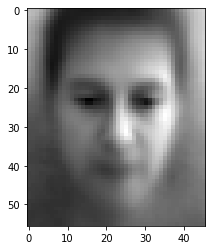

In [6]:
A, X_bar = AvgCompute(X_train) 
A = A.T

plt.imshow(np.reshape(X_bar,(46,56)).T, cmap = 'gist_gray') # 평균 얼굴 출력

In [35]:
### 1. S=(1/N)AAT 방식 ###
row, col = X_train.shape
start = time.time()
S = (A @ A.T) / row
eigvals_hi, eigvecs_hi = eig(S) # High dimnesional
time_hi = time.time()-start
eigvals_hi = np.real(eigvals_hi)
eigvecs_hi = np.real(eigvecs_hi)

print(eigvals_hi.shape)

(2576,)


In [36]:
### 2.  (1/N)ATA 방식 ###
start = time.time()
S = (A.T @ A) / row
eigvals_lo, eigvecs_lo = eig(S) # Low dimnesional
time_lo = time.time()-start
eigvals_lo = np.real(eigvals_lo)
eigvecs_lo = np.real(eigvecs_lo)

print(eigvals_lo.shape)
print(eigvecs_lo.shape)

(416,)
(416, 416)


* Pros : Effieciency of Computation
* Cons : 선택할 수 있는 EigenVector 수가 적다(?) -> Less accurate



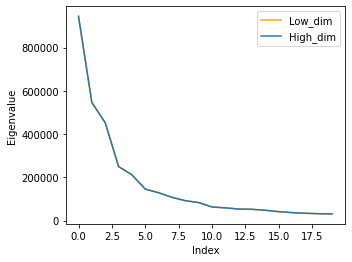

[[ 0.01472612 -0.01452073  0.02083939 -0.0010252   0.00149127]
 [ 0.01568776 -0.01451353  0.02166585 -0.00481855  0.00075976]
 [ 0.01620521 -0.01268219  0.02312839 -0.00612816  0.00139742]
 ...
 [-0.00386158  0.04922071 -0.01225171 -0.02995161 -0.00146651]
 [-0.00348498  0.04975527 -0.01235822 -0.03482284 -0.00056609]
 [-0.00338921  0.0502941  -0.01397589 -0.03552668  0.00163263]]
[[-0.01472612 -0.01452073  0.02083939  0.0010252   0.00149127]
 [-0.01568776 -0.01451353  0.02166585  0.00481855  0.00075976]
 [-0.01620521 -0.01268219  0.02312839  0.00612816  0.00139742]
 ...
 [ 0.00386158  0.04922071 -0.01225171  0.02995161 -0.00146651]
 [ 0.00348498  0.04975527 -0.01235822  0.03482284 -0.00056609]
 [ 0.00338921  0.0502941  -0.01397589  0.03552668  0.00163263]]
Computation time for high_dim PCA = 16.29594874382019
Computation time for low_dim PCA = 0.2721822261810303


In [37]:
### eigval / eigvec 비교 ###
# fig = plt.figure(figsize=(5,6))
# ax1 = fig.add_subplot(211)
# plt.title('Low_Dim')
# ax1.plot(range(0,20), eigvals_lo[:20], color='orange')
# ax2 = fig.add_subplot(212)
# plt.title('High_Dim')
# ax2.plot(range(0,20), eigvals_hi[:20])	 # 두 방식에서 eigenvalue 그래프가 동일함

plt.figure(figsize=(5,4))
plt.plot(range(0,20), eigvals_lo[:20], color='orange', label = "Low_dim")
plt.plot(range(0,20), eigvals_hi[:20], label = "High_dim")
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.show()


low = np.linalg.norm(A @ eigvecs_lo[:,:5], axis = 0)
print(eigvecs_hi[:,:5])
print(A @ eigvecs_lo[:,:5] / low[np.newaxis,:])             # low dim에서 A를 곱해주면 eigenvector 방향까지 동일해짐

print(f"Computation time for high_dim PCA = {time_hi}")
print(f"Computation time for low_dim PCA = {time_lo}")

In [34]:
count = 0

for i in eigvals_hi:
  if(i==0): count = count + 1

print(count)

0


1/91
2/91
3/91
4/91
5/91
6/91
7/91
8/91
9/91
10/91
11/91
12/91
13/91
14/91
15/91
16/91
17/91
18/91
19/91
20/91
21/91
22/91
23/91
24/91
25/91
26/91
27/91
28/91
29/91
30/91
31/91
32/91
33/91
34/91
35/91
36/91
37/91
38/91
39/91
40/91
41/91
42/91
43/91
44/91
45/91
46/91
47/91
48/91
49/91
50/91
51/91
52/91
53/91
54/91
55/91
56/91
57/91
58/91
59/91
60/91
61/91
62/91
63/91
64/91
65/91
66/91
67/91
68/91
69/91
70/91
71/91
72/91
73/91
74/91
75/91
76/91
77/91
78/91
79/91
80/91
81/91
82/91
83/91
84/91
85/91
86/91
87/91
88/91
89/91
90/91
91/91


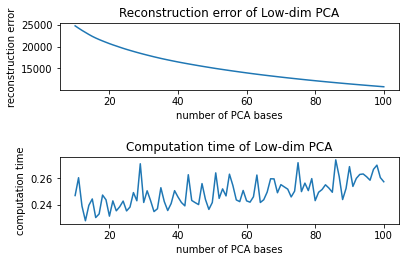

average computation time = 0.24931910797789858


In [10]:
# number of PCA bases 바꾸면서 reconstruction error 측정
max_num = 100
start_num = 10
error_list = []
computation_time = []

os.makedirs("./PCA_org", exist_ok=True)
os.makedirs("./PCA_low_dim", exist_ok=True)

# Original PCA / Low-dim PCA
low_dim=True
# low_dim=True
if low_dim:
    root_path = "./PCA_low_dim"
else:
    root_path = "./PCA_org"

for i in range(start_num, max_num+1):
    reconst_X, X_bar, principal_vals, principal_components, comp_time = PCA(X_train, i, low_dim)
    recon_loss = np.linalg.norm((X_train - reconst_X), None)
    error_list.append(recon_loss)
    computation_time.append(comp_time)
    # To see the reconstructed images
    plt.imsave(f"{root_path}/{i}_recon.png", np.reshape(reconst_X[0,:],(46,56)).T, cmap = 'gist_gray')
    print(f"{i-start_num+1}/{max_num-start_num+1}")

if not low_dim:
    PCA_name = "Original PCA"
else:
    PCA_name = "Low-dim PCA"

x_axis = list(range(start_num, max_num+1))
fig_recon, ax_recon = plt.subplots(2,1)
ax_recon[0].plot(x_axis, error_list)
ax_recon[0].set_xlabel("number of PCA bases")
ax_recon[0].set_ylabel("reconstruction error")
ax_recon[0].set_title(f"Reconstruction error of {PCA_name}")

ax_recon[1].plot(x_axis, computation_time)
ax_recon[1].set_xlabel("number of PCA bases")
ax_recon[1].set_ylabel("computation time")
ax_recon[1].set_title(f"Computation time of {PCA_name}")

fig_recon.tight_layout(pad=2.0)

plt.show()

print(f"average computation time = {np.mean(computation_time)}")